### import modules

In [1]:
# to remove depreciationWarning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

In [2]:
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

- Import NLTK for common stop words
- This list of stopwords will be extended. The extension words are corpus specific

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['city','davao','government','ordinance','series','mayor','otherwise','sign','behalf','code','barangay','purposes','memorandum','agreement','enter','authority','entered','section','public','amended','development','district','local','operation','thereof','management','within','legislative','program','relative','use'])
# stop_words.extend(['city','davao','government','ordinance','series','mayor','otherwise','sign','behalf','code','barangay','purposes','memorandum','agreement','enter','authority','entered','section','public','amended','ii'])

In [4]:
df = pd.read_csv('ordinances/davao_ordinances.csv', header = 0)
print(df)
df.head()

            OR                                                 OT
0    000172-14  An Ordinance amending Section 42 of the 2005 R...
1    000177-14  An Ordinance placing underground all electrica...
2    000178-14  An Ordinance amending City Ordinance No. 0195-...
3    000173-14  An Ordinance regulating the use of some street...
4    000227-14  An ordinance for the creation of Trust Fund Ac...
..         ...                                                ...
414  000496-13  An Ordinance authorizing the City Mayor to ent...
415  000487-16  An Ordinance amending Section 13 Article XI of...
416  000348-07  Ordinance  Establishing the Gender-Sensitive C...
417  000349-07  ORDINANCE AMENDING DAVAO CITY ORDINANCE NO. 15...
418  000355-07  An  Ordinance  for  the  "Davao  Branding  Sys...

[419 rows x 2 columns]


,OR,OT
0,000172-14,An Ordinance amending Section 42 of the 2005 R...
1,000177-14,An Ordinance placing underground all electrica...
2,000178-14,An Ordinance amending City Ordinance No. 0195-...
3,000173-14,An Ordinance regulating the use of some street...
4,000227-14,An ordinance for the creation of Trust Fund Ac...


Add ordinance descriptions to a list

In [5]:
data = list(df.OT) 
print(data[:1]) # preview

['An Ordinance amending Section 42 of the 2005 Revenue Code of Davao City from "Time and Place of the Payment - The tax shall be due and payable in advance to the City Treasurer or his duly authorized representative before the materials are extracted and shall be based on the volume applied for in the application for quarry concession" to "Tax shall be due and payable every quarter of the Calendar Year to the City Treasurer or his duly authorized representative after the materials are extracted based on the volume applied for in the application for quarry concession"']


Use regular expression to remove words ending with ING.
(Seems to improve topics)

In [6]:
import re
newStops = []
i = 0
# add words next to ordinance to stops words list 
while i < len(data):
    try:
        newStops.append(re.search(r'(?<=Ordinance )(\w+)', data[i]).group(1))
    except AttributeError:
        None
    i +=1
stop_words.extend(newStops)
print(len(data))
# print(new)

419


Tokenize and preprocess text

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['an',
  'ordinance',
  'amending',
  'section',
  'of',
  'the',
  'revenue',
  'code',
  'of',
  'davao',
  'city',
  'from',
  'time',
  'and',
  'place',
  'of',
  'the',
  'payment',
  'the',
  'tax',
  'shall',
  'be',
  'due',
  'and',
  'payable',
  'in',
  'advance',
  'to',
  'the',
  'city',
  'treasurer',
  'or',
  'his',
  'duly',
  'authorized',
  'representative',
  'before',
  'the',
  'materials',
  'are',
  'extracted',
  'and',
  'shall',
  'be',
  'based',
  'on',
  'the',
  'volume',
  'applied',
  'for',
  'in',
  'the',
  'application',
  'for',
  'quarry',
  'concession',
  'to',
  'tax',
  'shall',
  'be',
  'due',
  'and',
  'payable',
  'every',
  'quarter',
  'of',
  'the',
  'calendar',
  'year',
  'to',
  'the',
  'city',
  'treasurer',
  'or',
  'his',
  'duly',
  'authorized',
  'representative',
  'after',
  'the',
  'materials',
  'are',
  'extracted',
  'based',
  'on',
  'the',
  'volume',
  'applied',
  'for',
  'in',
  'the',
  'application',
  'f

In [8]:
# Remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]



data_words_nostops = remove_stopwords(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1])

from collections import defaultdict

freq = defaultdict(int)
for text in texts:
    for token in text:
        freq[token] += 1              
sorted_freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
pprint(sorted_freq[:50])


[('fund', 31),
 ('construction', 31),
 ('business', 30),
 ('center', 27),
 ('establishment', 26),
 ('department', 26),
 ('health', 26),
 ('office', 23),
 ('new', 23),
 ('fees', 22),
 ('hundred', 22),
 ('tax', 21),
 ('inc', 21),
 ('national', 20),
 ('pesos', 20),
 ('article', 19),
 ('establishments', 19),
 ('rules', 19),
 ('implementation', 18),
 ('investment', 18),
 ('located', 18),
 ('one', 18),
 ('deed', 18),
 ('regulations', 18),
 ('street', 18),
 ('revenue', 17),
 ('year', 17),
 ('market', 17),
 ('risk', 17),
 ('council', 17),
 ('five', 17),
 ('food', 17),
 ('project', 16),
 ('reduction', 16),
 ('among', 16),
 ('matina', 16),
 ('guidelines', 15),
 ('area', 15),
 ('disaster', 15),
 ('amount', 15),
 ('maintenance', 15),
 ('donation', 15),
 ('penalties', 15),
 ('streets', 14),
 ('prescribing', 14),
 ('two', 14),
 ('anti', 14),
 ('million', 14),
 ('executed', 14),
 ('favor', 14)]


In [9]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# from gensim import corpora, models
# tfidf = models.TfidfModel(corpus)
# corpus_tfidf = tfidf[corpus]
# from pprint import pprint
# for doc in corpus_tfidf:
#     pprint(doc)
#     break 

[[('advance', 1),
  ('application', 2),
  ('applied', 2),
  ('authorized', 2),
  ('based', 2),
  ('calendar', 1),
  ('concession', 2),
  ('due', 2),
  ('duly', 2),
  ('every', 1),
  ('extracted', 2),
  ('materials', 2),
  ('payable', 2),
  ('payment', 1),
  ('place', 1),
  ('quarry', 2),
  ('quarter', 1),
  ('representative', 2),
  ('revenue', 1),
  ('tax', 2),
  ('time', 1),
  ('treasurer', 2),
  ('volume', 2),
  ('year', 1)]]

In [10]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=123,
                                           chunksize=100,
                                           passes=30,
                                           workers=3,
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

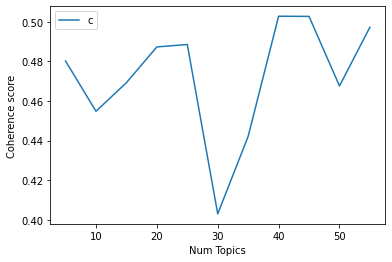

Model: ( 0 ) Num Topics = 5  has Coherence Value of 0.4802
Model: ( 1 ) Num Topics = 10  has Coherence Value of 0.4548
Model: ( 2 ) Num Topics = 15  has Coherence Value of 0.4693
Model: ( 3 ) Num Topics = 20  has Coherence Value of 0.4873
Model: ( 4 ) Num Topics = 25  has Coherence Value of 0.4885
Model: ( 5 ) Num Topics = 30  has Coherence Value of 0.403
Model: ( 6 ) Num Topics = 35  has Coherence Value of 0.4422
Model: ( 7 ) Num Topics = 40  has Coherence Value of 0.5028
Model: ( 8 ) Num Topics = 45  has Coherence Value of 0.5028
Model: ( 9 ) Num Topics = 50  has Coherence Value of 0.4676
Model: ( 10 ) Num Topics = 55  has Coherence Value of 0.4973


In [11]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=5, limit=60, step=5)

# Show graph to find optimal number of topics
# Coherence value not going flat seems unlikely or probably wrong
limit=60; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
model_number = -1
for m, cv in zip(x, coherence_values):
    model_number += 1
    print("Model: (", model_number,") Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [26]:
optimal_model = model_list[9]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(18,
  '0.054*"halal" + 0.027*"food" + 0.018*"health" + 0.017*"tourism" + '
  '0.013*"inc" + 0.012*"muslim" + 0.012*"certifying" + 0.012*"word" + '
  '0.012*"posting" + 0.012*"name"'),
 (42,
  '0.014*"buildings" + 0.014*"center" + 0.014*"registration" + '
  '0.014*"discrimination" + 0.014*"committee" + 0.014*"sexual" + '
  '0.014*"sectors" + 0.014*"investigation" + 0.014*"investigating" + '
  '0.014*"harassment"'),
 (16,
  '0.031*"peace" + 0.024*"penalties" + 0.024*"children" + 0.021*"conflict" + '
  '0.020*"violations" + 0.014*"waste" + 0.014*"solid" + 0.014*"ecological" + '
  '0.014*"therefor" + 0.014*"acts"'),
 (10,
  '0.084*"comprehensive" + 0.047*"ordinances" + 0.037*"administration" + '
  '0.035*"zoning" + 0.035*"plan" + 0.035*"repeal" + 0.035*"enforcement" + '
  '0.035*"conflict" + 0.035*"therewith" + 0.027*"land"'),
 (9,
  '0.025*"buildings" + 0.019*"defacing" + 0.019*"view" + 0.019*"violation" + '
  '0.019*"penalties" + 0.019*"exposed" + 0.019*"prohibitng" + 0.019*"fences" + 

In [27]:


def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.9755,"investment, tax, incentive, article, related, provisions, street, regulations, rules, rule","An Ordinance amending Section 42 of the 2005 Revenue Code of Davao City from ""Time and Place of the Payment - The tax shall be due and payable in advance to the City Treasurer or his duly authorized representative before the materials are extracted and shall be based on the volume applied for in the application for quarry concession"" to ""Tax shall be due and payable every quarter of the Calendar Year to the City Treasurer or his duly authorized representative after the materials are extracted based on the volume applied for in the application for quarry concession"""
1,1,3.0,0.6688,"national, rerouting, scheme, insurance, philhealth, health, indigent, brother, international, relations",An Ordinance placing underground all electrical and telecommunication wires and cables within the vicinity of City Hall and the Sangguniang Panlungsod of the City of Davao
2,2,43.0,0.3367,"per, day, square, meter, wine, pasko, pesos, period, activities, particularly","An Ordinance amending City Ordinance No. 0195-14, Series of 2004, otherwise known as the ""Amended rerouting scheme of Davao City"" for a 90-day experimental period"
3,3,48.0,0.8600,"act, legal, philippines, designated, staff, mintal, lawyer, general, gaa, year","An Ordinance regulating the use of some streets near the Mintal Public Market in Barangay Mintal, Tugbok District, this city"
4,4,38.0,0.9574,"internet, cafe, establishments, business, covered, area, aplaya, matina, housing, beach",An ordinance for the creation of Trust Fund Account for the Office of the Building Official and prescribing procedural guidelines for the disposition and use of the Fifteen Percent (15%) generated from building permit fees and other charges under the National Building Code of the Philippines (PD 1096)
5,5,18.0,0.5100,"halal, food, health, tourism, inc, muslim, certifying, word, posting, name",An ordinance amending the Tourism Code of Davao City
6,6,24.0,0.5016,"benefits, sections, cemetery, revenue, workers, particularly, article, scholars, qualified, funds","An Ordinance granting Legislative Authority to City Mayor Rodrigo R. Duterte to enter into and sign, for and in behalf of the City Government of Dava (CGD), the Partnership Agreement between the Philippine Commission on Women and the City Government of Davao for the implementation of the Local Gender and Development Resource Program in Davao City"
7,7,0.0,0.7708,"institutions, understanding, center, region, xi, jail, mou, terminals, three, area","An ordinance granting legislative authority to City Mayor Rodrigo R. duterte, to sign for and in behalf of the City Government of Davao the Memorandum of Understanding to be entered into by and between Alsons Development & Investment Corporation (ALSONS DEV) and the City Government of Davao relative to the establishment of 911 Satellite Office in Cabantian, Davao City"
8,8,20.0,0.6733,"jurisdiction, territorial, motorcycle, collection, prescribing, year, take, real, effect, fair",An Ordinance regulating motorcades within the territorial jurisdiction of Davao City
9,9,0.0,0.5743,"institutions, understanding, center, region, xi, jail, mou, terminals, three, area","An ordinance authorizing the City Mayor, Rodrigo R. Duterte, to enter into and sign, for and in behalf of the City Government of Davao, the Memorandum of Understanding (MOU) of the Friendship City Agreement between Davao City and Lucena City"


In [28]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 1000

documents_topic = pd.DataFrame()


sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Most Representative Text"]

# Show
sent_topics_sorteddf.head(55)

,Topic_Num,Topic_Perc_Contrib,Keywords,Most Representative Text
0,0.0,0.9782,"institutions, understanding, center, region, xi, jail, mou, terminals, three, area","An Ordinance requiring all establishments, whether commercial, industrial or financial institutions, with capitalization of not less than Three Million (P3,000,000.00) , including, but not limited to banks, pawnshops, restaurants, shopping malls, hotels, inns, educational institutions, hospitals and medical institutions, gaming cockpits (sabungan) and private transportation terminals operating on land, air and sea, operation within the City of Davao, to install, operate and maintain Closed Circuit Televisions (CCTVs) camera/s in public/common area/s"
1,1.0,0.9684,"donation, deed, favor, located, executed, franchising, hire, regulatory, land, road","An Ordinance accepting the Deed of Donation of several parcels of land executed by Jonathan T. Cua of Jonrain Realty Ventures, Inc., represented by Rainier B. Cua, in favor of the City Government of Davao, and authorizing the City Mayor to sign the Deed of Donation, for and in behalf of the City Government of Davao, involving road lots and open spaces of Orchard Lane Homes located in Barangay Los Amigos, Tugbok District, this City"
2,2.0,0.9592,"phase, tibungco, scheme, relocation, pricing, seven, every, rules, subject, existing","Ordinance authorizing the City Mayor`s Office to implement a scheme to collect payment of necessary business permit fees for Short-Term or Seasonal Businesses prior to inspection, otherwise known as ""Pay-Now Inspect-Later"" Policy subject to existing rules and regulations"
3,3.0,0.9623,"national, rerouting, scheme, insurance, philhealth, health, indigent, brother, international, relations",An Ordinance creating a PHILHEALTH Capitation Fund from the proceeds of the outpatient consultation and diagnostic benefit package to be provided by the Philippine Health Insurance Corporation (PHILHEALTH) for the qualified indigent families of the City of Davao under the indigent sector component of the National Health Insurance Program (NCIP)
4,4.0,0.9703,"sticks, serving, food, block, poblacion, lot, barrio, legal, office, represent","Requiring persons and/or business establishements such as restaurants, carenderias, food stalls and other related outlets serving barbecued meat such as pork, beef, fish or any food preparation needing the use of bamboo sticks or skewers to remove the pointed sticks completely or cut their sharp ends before serving to customers, and providing penalties for violations thereof"
5,5.0,0.9347,"business, establishments, permits, employing, employees, ten, drug, random, renewal, requirement","An Ordinance allowing St. Peter chapels to operate a Crematorium at their funeral Parlor as an additional service or business line located at Barangay Panacan, Bunawan District, this City."
6,6.0,0.9484,"salumay, datu, unit, plantilla, positions, gender, trucks, hauling, cargo, specific","Amending Section 1 of Ordinance No. 2597, series of 1995, as amended by Ordinance No. 134, series of 2001, otherwise known as ""An Ordinance Banning the Entry of Cargo/Hauling Trucks in Certain Streets of the City of Davao during specific hours of the day and for other purposes"", by exempting cargo/hauling trucks carrying fruits and vegetables which are perishable in nature"
7,7.0,0.9555,"support, tower, self, buhangin, inc, globe, meter, site, funds, functions","AN ORDINANCE GRANTING LEGISLATIVE AUTHORITY TO EFB GEOSTRUCKT, INC. FOR THE CONSTUCTION, INSTALLATION AND OPERATION OF GLOBE TELECOM`S 40.0 METER 3-LEGGED SELF SUPPORT CELL SITE TOWER AT TIGATTO ROAD, BREAD VILLAGE, BARANGAY BUHANGIN PROPER, BUHANGIN DISTRICT,THIS CITY"
8,8.0,0.9728,"sale, deed, matina, new, services, phase, sites, area, commercial, sr","An Ordinance creating Ten (10) Barangays out of the mother Barangay of Agdao, Buhangin District, Davao City, to be named as : 1. Barangay Leon Garcia Sr.; 2. Barangay Kapitan Tomas Monteverde Sr.; 3.

In [31]:
# df_sorted_by_topic = df_dominant_topic.sort_values(by=['Dominant_Topic'])
# documents with topic 7.0 as dominant topic
df_sorted_by_topic = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 47.0]

df_sorted_by_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
21,21,47.0,0.9109,"anti, nuisance, office, revised, violation, service, one, division, board, functions",An ordinance granting barangay length of service benefits/incentives to all barangay elected officials after their tenure of office and providing funds therefor
51,51,47.0,0.6689,"anti, nuisance, office, revised, violation, service, one, division, board, functions","Amending Ordinance No. 2597, series of 1995, exempting from its coverage cement mixers actually used in government construction projects in the City of Davao"
72,72,47.0,0.8137,"anti, nuisance, office, revised, violation, service, one, division, board, functions","An Ordinance prohibiting all persons , entities, and business establishments in Davao City to charge any fee to senior citizens and persons with disability, for the use of any restroom or comfort room, and providing penalties for violation thereof"
160,160,47.0,0.8010,"anti, nuisance, office, revised, violation, service, one, division, board, functions",An Ordinance requiring all motocycle drivers and riders plying along city streets and national highways within the territorial jurisdiction of Davao City to wear crash helmets of any kind while operating said motorcycle and providing penalty for violation thereof.
172,172,47.0,0.9300,"anti, nuisance, office, revised, violation, service, one, division, board, functions","An ordinance prohibiting any person from urinating and/or defecating within the public view in any street, alley, highway and any place within the vicinity of any public building in Davao City and providing penalties in case of violation thereof."
174,174,47.0,0.8367,"anti, nuisance, office, revised, violation, service, one, division, board, functions","Ordinance creating the City Cooperative Development Office (CCDO), appropriating funds therefor, and for other purposes"
264,264,47.0,0.4040,"anti, nuisance, office, revised, violation, service, one, division, board, functions","An Ordinance to amend and revise Ordinance No. 142, series of 1955, otherwise known as ""THE ANTI -NUISANCE ORDINANCE""."
318,318,47.0,0.8911,"anti, nuisance, office, revised, violation, service, one, division, board, functions","An Ordinance authorizing the City Mayor to enter into and sign, for and in behalf of the City Government of Davao, the Memorandum of Agreement to be entered into by and between the City Government of Davao and the Office of the Presidential Adviser on the Peace Process for the Social Integration Program (SIP), as amended"
324,324,47.0,0.9183,"anti, nuisance, office, revised, violation, service, one, division, board, functions","AN ORDINANCE AMENDING CERTAIN PROVISIONS OF ORDINANCE NO. 514, SERIES OF 1985, RECONSTITUTING THE MEMBERSHIP OF THE DAVAO CITY RECREATION CENTER (DCRC) BOARD OF TRUSTEES, DEFINING ITS POWERS AND FUNCTIONS"
345,345,47.0,0.9020,"anti, nuisance, office, revised, violation, service, one, division, board, functions","An Ordinance amending Ordinance No. 30, Series of 1988, entitled ""An Ordinance amending and revising Ordinance No. 142, Series of 1955, otherwise known as the ""Anti-nuisance Ordinance"" to be knwon as ""The Revised Anti-Nuisance Ordinance of Davao City"" defining nuisance, prohibiting the same, punishing violation thereof and for other purposes"


/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [24]:
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
pyLDAvis.display(vis)



/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [25]:
# # 1. Wordcloud of Top N words in each topic
# from matplotlib import pyplot as plt
# from wordcloud import WordCloud, STOPWORDS
# import matplotlib.colors as mcolors

# cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# cloud = WordCloud(stopwords=stop_words,
#                   background_color='white',
#                   width=2500,
#                   height=1800,
#                   max_words=15,
#                   colormap='tab20',
#                   color_func=lambda *args, **kwargs: cols[i],
#                   prefer_horizontal=1.0)

# topics = optimal_model.show_topics(num_topics=15,formatted=False)

# fig, axes = plt.subplots(3, 5, figsize=(12,8), sharex=True, sharey=True)

# for i, ax in enumerate(axes.flatten()):
#     fig.add_subplot(ax)
#     topic_words = dict(topics[i][1])
#     cloud.generate_from_frequencies(topic_words, max_font_size=300)
#     plt.gca().imshow(cloud)
#     plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
#     plt.gca().axis('off')


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
# plt.margins(x=0, y=0)
# plt.tight_layout()
# plt.show()

In [18]:
# import seaborn as sns
# import matplotlib.colors as mcolors
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# fig, axes = plt.subplots(3,5,figsize=(12,8), dpi=160, sharex=True, sharey=True)
# # These are the "Tableau 20" colors as RGB.    
# tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
#              (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
#              (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
#              (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
#              (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
# for i in range(len(tableau20)):    
#     r, g, b = tableau20[i]    
#     tableau20[i] = (r / 255., g / 255., b / 255.)
    
# for i, ax in enumerate(axes.flatten()):    
#     df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
#     doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
#     ax.hist(doc_lens, bins = 700, color=tableau20[i])
#     ax.tick_params(axis='y', labelcolor=tableau20[i], color=tableau20[i])
#     sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
#     ax.set(xlim=(0, 700), xlabel='Document Word Count')
#     ax.set_ylabel('Number of Documents', color=tableau20[i])
#     ax.set_title('Topic: '+str(i), fontdict=dict(size=5, color=tableau20[i]))

# fig.tight_layout()
# fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0,700,9))
# fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
# plt.show()

In [19]:

# # Sentence Coloring of N Sentences
# from matplotlib.patches import Rectangle

# def sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 15):
#     corp = corpus[start:end]
#     mycolors = tableau20

#     fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
#     axes[0].axis('off')
#     for i, ax in enumerate(axes):
#         if i > 0:
#             corp_cur = corp[i-1] 
#             topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
#             word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
#             ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
#                     fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

#             # Draw Rectange
#             topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
#             ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
#                                    color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

#             word_pos = 0.06
#             for j, (word, topics) in enumerate(word_dominanttopic):
#                 if j < 14:
#                     ax.text(word_pos, 0.5, word,
#                             horizontalalignment='left',
#                             verticalalignment='center',
#                             fontsize=16, color=mycolors[topics],
#                             transform=ax.transAxes, fontweight=700)
#                     word_pos += .009 * len(word)  # to move the word for the next iter
#                     ax.axis('off')
#             ax.text(word_pos, 0.5, '. . .',
#                     horizontalalignment='left',
#                     verticalalignment='center',
#                     fontsize=16, color='black',
#                     transform=ax.transAxes)       

#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
#     plt.tight_layout()
#     plt.show()

# sentences_chart()